In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
df = pd.read_csv(r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Outcome\processed_sequence_data.csv")

# Compute Power
df['Power'] = df['Voltage'] * df['Current']

# Normalize input features
features = ['Voltage', 'Current', 'Temperature', 'Power']
target = 'SOC'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Split train/test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [3]:
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, window_size=100, batch_size=64):
        self.X = X
        self.y = y
        self.window_size = window_size
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.X) - self.window_size) // self.batch_size

    def __getitem__(self, idx):
        Xs, ys = [], []
        start_idx = idx * self.batch_size
        for i in range(start_idx, start_idx + self.batch_size):
            Xs.append(self.X[i:i+self.window_size])
            ys.append(self.y[i+self.window_size])
        return np.array(Xs), np.array(ys)


In [4]:
window_size = 100
batch_size = 64

train_gen = SequenceGenerator(X_train, y_train, window_size, batch_size)
val_gen = SequenceGenerator(X_val, y_val, window_size, batch_size)


In [5]:
model = Sequential([
    LSTM(64, input_shape=(window_size, len(features)), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output SOC
])


In [6]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19777 (77.25 KB)
Trainable params: 19777 (77.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    verbose=1
)



11614/11614 [==============================] - 582s 50ms/step - loss: 0.0021 - mae: 0.0323 - val_loss: 5.9650e-04 - val_mae: 0.0178


In [9]:
history.history['mae']           # Training MAE per epoch
history.history['val_mae']       # Validation MAE per epoch

[0.017795100808143616]

In [10]:
# Gather predictions
y_true, y_pred = [], []
for X_batch, y_batch in val_gen:
    preds = model.predict(X_batch)
    y_true.append(y_batch)
    y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# Inverse scale
y_true_inv = scaler_y.inverse_transform(y_true)
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)




2/2 [==============================] - 0s 16ms/step


In [11]:
print(f"MAE:  {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²:   {r2:.5f}")

MAE:  0.01780
RMSE: 0.02442
R²:   0.99327


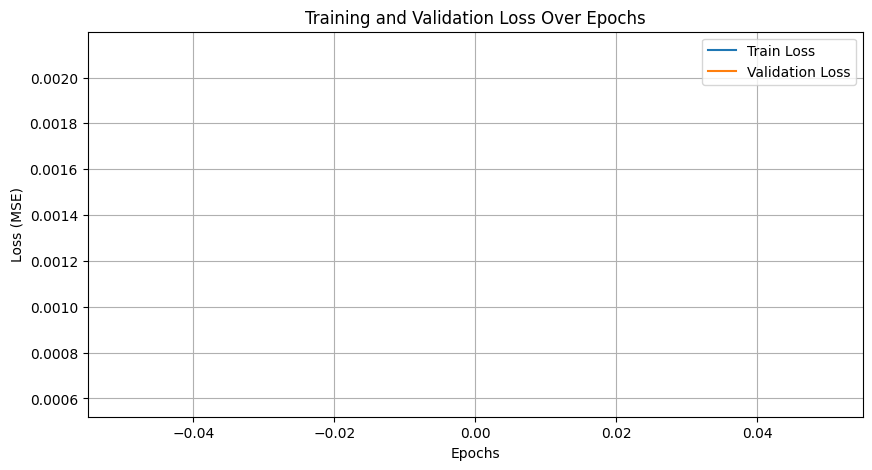

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

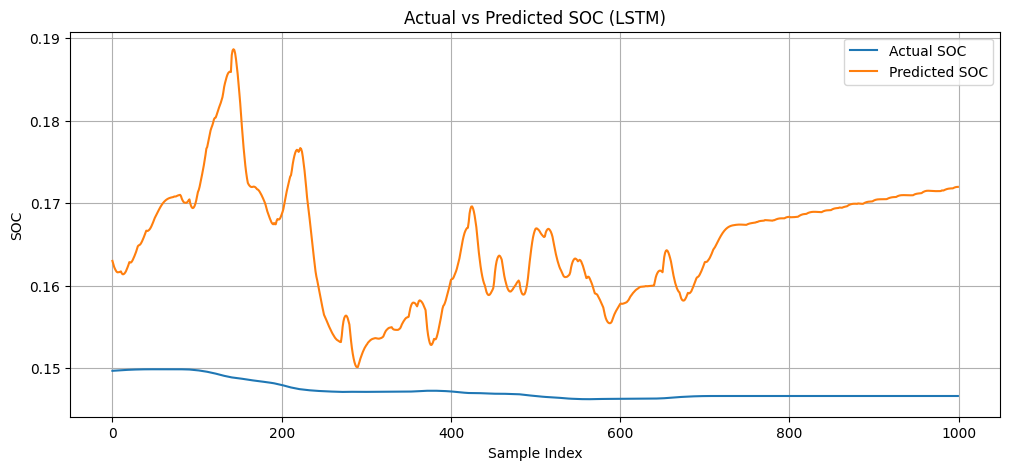

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y_true_inv[:1000], label='Actual SOC')
plt.plot(y_pred_inv[:1000], label='Predicted SOC')
plt.title("Actual vs Predicted SOC (LSTM)")
plt.xlabel("Sample Index")
plt.ylabel("SOC")
plt.legend()
plt.grid()
plt.show()


In [14]:
errors = y_true_inv.flatten() - y_pred_inv.flatten()
sns.histplot(errors, bins=50, kde=True)
plt.title("SOC Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.grid()
plt.show()


NameError: name 'sns' is not defined

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_inv, y_pred_inv, alpha=0.3)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Actual SOC")
plt.ylabel("Predicted SOC")
plt.title("Predicted vs Actual SOC")
plt.axis('square')
plt.grid()
plt.show()


In [ ]:
model.save("lstm_soc_model.h5")
model.save("lstm_soc_model.keras")
print("✅ Model saved as lstm_soc_model.h5")
